# Active Continuous DA from GTA5 to Cityscapes

This notebook performs active sample selection using MADA and generalizes the vgg16-deeplabv3 from source to target.

In [1]:
# End-End training and testing of the new pytorch-based VGG16-deeplabv3 architecture
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import importlib

import wasserstein_utils
import data_utils
import losses
import networks
import deeplabv3 as dlv3
import utils

In [3]:
import time
import numpy as np

import data_utils
import losses

from IPython import display

In [4]:
import umap

In [5]:
backbone = 'vgg16'
dataset = "GTA5"

# H x W x C
img_shape = (512,1024,3)

# 19 classes + void
num_classes = 20

batch_size=4

# Testing replay buffer => training off
do_training = False

epochs=250
epoch_step=250

num_projections=100

source_data_dir = './processed-data/1024x512/19_classes/' + dataset + '/train/'
cityscapes_data_dir = './processed-data/1024x512/19_classes/CITYSCAPES/train/'
cityscapes_val_dir = './processed-data/1024x512/19_classes/CITYSCAPES/val/'

fn_w_dlv3 = "weights/" + dataset + "/" + backbone + "_deeplabv3.h5"
fn_w_cls = "weights/" + dataset + "/" + backbone + "_deeplabv3_classifier.h5"

fn_w_adapted_dlv3 = "weights/" + dataset + "/" + backbone +"_deeplabv3_adapted.h5"
fn_w_adapted_cls = "weights/" + dataset + "/" + backbone + "_deeplabv3_classifier_adapted.h5"

## Step 1: Model Construction

This builds a customized deeplabv3 model with classifier layer

In [6]:
importlib.reload(losses)

deeplabv3 = dlv3.deeplabv3(activation=None, \
                           backbone=backbone, \
                           num_classes=num_classes)

X = deeplabv3.input
Y = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,), dtype='float32', name='label_input')

C_in = tf.keras.layers.Input(shape=deeplabv3.layers[-1].output_shape[1:], dtype='float32', name='classifier_input')
classifier = tf.keras.Model(C_in, networks.classifier_layers(C_in, num_classes = num_classes, activation='softmax'))

# A combined model, giving the output of classifier(deeplabv3(X))
combined = tf.keras.Model(X, classifier(deeplabv3(X)))
combined.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# A model outputting hxwx1 labels for each image. Also useful to verify the
# mIoU with Keras' built-in function. Will however also consider the 'ignore' class. 
combined_ = tf.keras.Model(X, tf.cast(tf.keras.backend.argmax(combined(X), axis=-1), 'float32'))
combined_.compile(metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# Set up training
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-8, decay=1e-6)
# opt = tf.keras.optimizers.SGD(lr=1e-4, momentum=.9)

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y, classifier(deeplabv3(X)), from_logits=False)

# https://stackoverflow.com/questions/55434653/batch-normalization-doesnt-have-gradient-in-tensorflow-2-0
params = deeplabv3.trainable_weights + classifier.trainable_weights

updates = opt.get_updates(wce_loss, params)

train = tf.keras.backend.function(inputs=[X,Y], outputs=[wce_loss], updates=updates)

In [7]:
deeplabv3.load_weights(fn_w_dlv3)
classifier.load_weights(fn_w_cls)

### Model Summary
This final `combined_` model is consists of (deeplabv3 + classifer). More specifically, `combined` outputs categorical cross entroy and `combined_` outputs Height * Weight * 1 labels.

In [8]:
combined_.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 1024, 3)]    0         
_________________________________________________________________
model_2 (Model)              (None, 512, 1024, 20)     19446008  
_________________________________________________________________
tf_op_layer_ArgMax (TensorFl [(None, 512, 1024)]       0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow [(None, 512, 1024)]       0         
Total params: 19,446,008
Trainable params: 19,442,424
Non-trainable params: 3,584
_________________________________________________________________


## Step 2: Training on Source Domain

This step can be skipped by loading pretrained model weights.

In [9]:
importlib.reload(data_utils)
import matplotlib.pyplot as plt

# Training on source domain
if do_training == True:
    
    try:
        deeplabv3.load_weights(fn_w_dlv3)
        classifier.load_weights(fn_w_cls)
        print("Successfully loaded model. Continuing training.")
    except:
        print("Could not load previous model weights. Is a new model present?")
        
    start_time = time.time()

    fig,ax = plt.subplots(1,figsize=(10,7))

    loss_history = []
    
    for itr in range(epochs):
        
        source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=batch_size, seed=itr)
        source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

        loss_history.append(train(inputs=[source_train_data, source_train_labels]))
        
        if np.isnan(np.sum(loss_history[-1])):
            print('ERROR. ENCOUNTERED NAN')
            break

        if itr%epoch_step == 0:
            if itr != 0:
                ax.clear()
                ax.plot(np.asarray(loss_history))

            ax.set_title("Training loss on source domain")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")

            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-3)
            
        if itr % (epochs // 10) == 0 or itr == epochs - 1:
            deeplabv3.save_weights(fn_w_dlv3)
            classifier.save_weights(fn_w_cls)

    training_time = time.time() - start_time
    
else:   
    deeplabv3.load_weights(fn_w_dlv3)
    classifier.load_weights(fn_w_cls)
    print("Loaded model weights from weights folder")

Loaded model weights from weights folder


In [ ]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_19, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# road 0.8559070065772992
# sidewalk 0.9043721610536399
# building 0.8381948427759653
# wall 0.632677142340526
# fence 0.699526703820766
# pole 0.6073661307913504
# traffic light 0.7258756809296298
# traffic sign 0.6789546854786402
# vegetation 0.8526590005209183
# terrain 0.7779495588027171
# sky 0.9530645387149239
# person 0.7316948194592244
# rider 0.809945935261575
# car 0.5922120101790109
# truck 0.9211600020912953
# bus 0.9270433021188236
# train 0.8659149467023691
# motorcycle 0.6754852581619956
# bicycle 0.5876167577346231
# 0.7704010780797522
# Computed GTA5 mIoU in 1953.6462309360504

In [ ]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.4538541445555259
# sidewalk 0.17761519682584992
# building 0.5960010633542256
# wall 0.11064090337021892
# fence 0.08225737548235189
# pole 0.11701661235497808
# traffic light 0.2131517695419058
# traffic sign 0.085832471689785
# vegetation 0.7016830692115976
# terrain 0.05272756739697445
# sky 0.4267235195286716
# person 0.30570697364634025
# rider 0.03181916445284627
# car 0.4930313336164962
# truck 0.05910168795933546
# bus 0.052471835602942996
# train 0.003952731749887269
# motorcycle 0.07819570698033228
# bicycle 0.0073530220468457285
# 0.2131124289140585
# Computed CITYSCAPES mIoU in 249.57955932617188

### Active Learning: Feature Map Generation and Centroids Clustering

This step generates a feature map from the source dataset. It then clusters the features into centroids. 

In [21]:
deeplabv3.summary() # This is the freezed feature encode f_E

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1024, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 1024, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 1024, 64 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 512, 64) 0           block1_conv2[1][0]               
______________________________________________________________________________________________

### Feature Map Generation
Feature encoder f_E (deeplabv3), calculate the feature map Fc(x) of a source sample x for a certain categorty c. y_c denotes the label map for category c. Square multiply denotes element wise multiplication for extraction of categorty-exclusive information. |A_c| is the number of pixels belonging to the specific category. 

![feature map formula](images/feature-formula.png)

The final feature vector F(x) of the source x is obtained by first flattening the F_c(x) of each categroty into a vector, and then connect vectors of all categories into a long vector. 

In [26]:
# Iterate through the source domains, for sample x
for itr in range(1):
    # train_data = (batch_size, 512, 1024, 3 channels); train_label = (batch_size, 512, 1024, 20 classes)
    source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=1, seed=itr)
    source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

In [90]:
# f_E(x), the networks' output for source sample x
output = deeplabv3(source_train_data)

In [91]:
# category c
c = 1

In [92]:
# f_E(x)|c, the networks' output for category c, shape(1, 512, 1024)
output[:,:,:,c] 

<tf.Tensor: shape=(1, 512, 1024), dtype=float32, numpy=
array([[[1.8430418, 1.8929796, 1.9429173, ..., 4.4713798, 4.4713798,
         4.4713798],
        [1.863036 , 1.91791  , 1.9727838, ..., 4.61341  , 4.61341  ,
         4.61341  ],
        [1.8830302, 1.9428403, 2.0026503, ..., 4.7554398, 4.7554398,
         4.7554398],
        ...,
        [5.167786 , 5.4404817, 5.713177 , ..., 4.4859176, 4.4859176,
         4.4859176],
        [5.167786 , 5.4404817, 5.713177 , ..., 4.4859176, 4.4859176,
         4.4859176],
        [5.167786 , 5.4404817, 5.713177 , ..., 4.4859176, 4.4859176,
         4.4859176]]], dtype=float32)>

In [93]:
# y_c, the label map for category c, numpy array with shape (1, 512, 1024)
source_train_labels[:,:,:,c]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]], dtype=float32)

In [94]:
# Extract category-exclusive information; element wise multiplication to get y_c * f_E(x)
tf.math.multiply(output[:,:,:,c], source_train_labels[:,:,:,c])

<tf.Tensor: shape=(1, 512, 1024), dtype=float32, numpy=
array([[[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [5.167786 , 5.4404817, 5.713177 , ..., 0.       , 0.       ,
         0.       ],
        [5.167786 , 5.4404817, 5.713177 , ..., 0.       , 0.       ,
         0.       ],
        [5.167786 , 5.4404817, 5.713177 , ..., 0.       , 0.       ,
         0.       ]]], dtype=float32)>

In [95]:
# |A_c|, the number of pixels beloing to the specific category
np.sum(source_train_labels[:,:,:,c])

219317.0

In [96]:
# F_c_x: feature map of a source sample x for a certain category c
F_c_x = tf.math.multiply(output[:,:,:,c], source_train_labels[:,:,:,c]) / np.sum(source_train_labels[:,:,:,c])
F_c_x

<tf.Tensor: shape=(1, 512, 1024), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [2.3563089e-05, 2.4806475e-05, 2.6049860e-05, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [2.3563089e-05, 2.4806475e-05, 2.6049860e-05, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [2.3563089e-05, 2.4806475e-05, 2.6049860e-05, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)>

In [107]:
# F_x: the final feature vector of the source image x,
# 1. flatten the F_c_x into a vector; here just squeeze into a 512*1024 vector
#    the original MADA uses some sort of avgpool2D to get a vector of size 256
#.   We can possibly use tf.image.resize(), but the input is a 4-D tensor of [batch, height, width, channels]
# 2. F_x = [c, v(F_c_x)], shape = (num_class, F_c_x flattened size)
tf.reshape(F_c_x, [-1])

<tf.Tensor: shape=(524288,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In summary, the feature generation step should look like:
```python
# shape = (number of images, (10 x vector size))
full_objective_vector = np.zeros([len(source_data), 20, vector_size]) 
for i_iter, image, label in source_data:
    f_E = deeplabv3(image)
    F_x = np.zeros(20, vector_size) # feature map for this image
    for c in range(0,19): # 20 classes
        F_c_x = tf.math.multiply(f_E[:,:,:,c], label[:,:,:,c]) / np.sum(label[:,:,:,c])
        F_c_x = tf.reshape(F_c_x, [-1])
        F_x[c] = F_c_x
    full_objective_vector[i_iter, :] = F_x[:]
```
The `full_objective_vector` is the feature map on the entire dataset. It can be saved to a file to later usages. 

### Clustering Anchors

After we have the full_objective_vector, we use the k-means method to group feature vectors of all source images into **k** clusters. 

![cluster-formula](images/cluster-formula.png)

The A_k is the centroid of cluster Ck. It is the source domain anchor, against which the target images will be compared for active sample selection. 

![anchor-formula](images/anchor-formula.png)

## Step 3: Loading Replay Buffer

Load the replay buffer from the source data, which stores a portion of previously seen data.

In [9]:
import replay_buffer_utils as rb_utils

start_time = time.time()
source_domain_portion = 0.1
replay_buffer = rb_utils.replay_buffer(source_data_dir, source_domain_portion)
print(time.time() - start_time)
print(replay_buffer.capacity)

36.719534158706665
4993


## Step 4: Continous adaptation to the target domain

Set up the train/loss computation on target domain and perform training

In [10]:
importlib.reload(wasserstein_utils)

Z_s = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], 3,) )
Y_s = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') #labels of input images oneHot
lambda2 = 5e-1

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y_s, classifier(deeplabv3(Z_s)), from_logits=False)

# Wasserstein matcing loss
theta = tf.keras.backend.placeholder(shape = (num_projections, num_classes), dtype='float32')
matching_loss = wasserstein_utils.sWasserstein_hd(deeplabv3(X), deeplabv3(Z_s), theta, nclass=num_classes, Cp=None, Cq=None,)

# Overall loss is a weighted combination of the two losses
total_loss = wce_loss + lambda2*matching_loss

params = deeplabv3.trainable_weights + classifier.trainable_weights

# Optimizer and training setup
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-6, decay=1e-6)
print(X.shape)
print(Z_s.shape)
print(Y_s.shape)
print(theta.shape)

updates = opt.get_updates(total_loss, params)
train = tf.keras.backend.function(inputs=[X,Z_s,Y_s,theta], outputs=[total_loss, wce_loss, matching_loss], updates=updates)

(None, 512, 1024, 3)
(None, 512, 1024, 3)
(None, 512, 1024, 20)
(100, 20)


/global/homes/z/zuang99/.conda/envs/MAS/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
loss = []
target_miou = []

deeplabv3.load_weights(fn_w_dlv3)
classifier.load_weights(fn_w_cls)

## Active target sample selection against source anchors

In this adaptation to target step, we should perform the active sample selection, using the following formula.

![target-sample-selection](images/target-sample-selection.png)

9533.819923877716


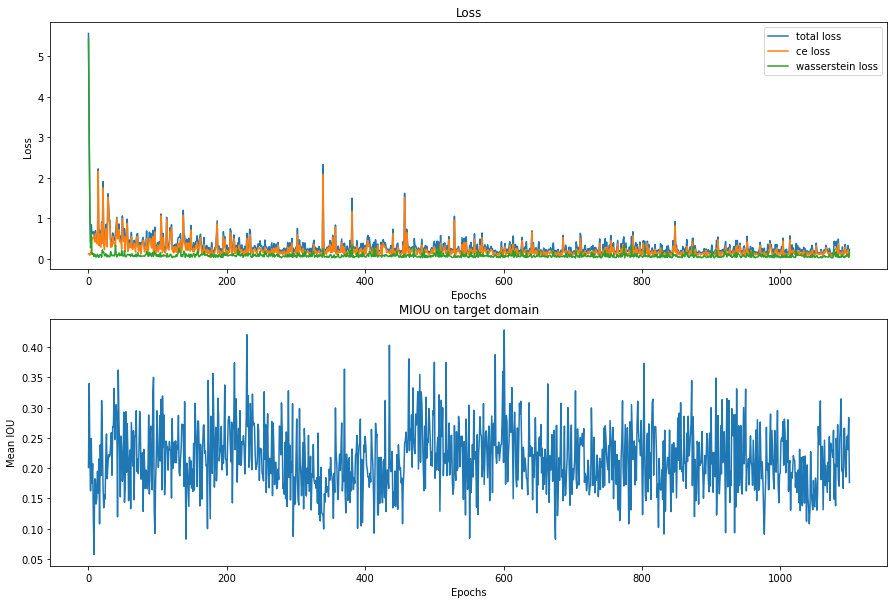

In [12]:
start_time = time.time()


fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 1

thres = .99
epochs2 = 1200
epochstep = 100

for itr in range(epochs2):
    if (itr % 100 == 0):
        print(itr)
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    
    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)
    
    ###   replay buffer photo version    
    X, Y = rb_utils.random_sample_replay(replay_buffer, 1)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    # print(X.shape)
    # print(Y.shape)
    loss.append(train(inputs=[target_train_data, X, Y, theta_instance]))
    ###   replay buffer photo version ends here
    
    target_miou.append(combined_.evaluate(target_train_data, target_train_labels, verbose=False)[-1] * 20/19)
    
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3)
    
print(time.time() - start_time)

In [13]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_19, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# road 0.6675523660118785
# sidewalk 0.28336359271439726
# building 0.6076388775470897
# wall 0.2672064026700072
# fence 0.17232300484931942
# pole 0.2735294951039704
# traffic light 0.32147051090247314
# traffic sign 0.07400171986539407
# vegetation 0.5965591779805058
# terrain 0.2889806932148324
# sky 0.8603173835723591
# person 0.3489449704700763
# rider 0.17189785226832072
# car 0.5761907340114261
# truck 0.2955718142857747
# bus 0.14318027819603177
# train 0.033001835642511974
# motorcycle 0.12385339561083183
# bicycle 0.025308995240981697
# 0.3226785842188517
# Computed GTA5 mIoU in 1957.6215891838074

road 0.8969252263565725
sidewalk 0.791973061315036
building 0.6937540331029338
wall 0.3196389810845718
fence 0.48920540623954084
pole 0.5495385742180461
traffic light 0.62543947230715
traffic sign 0.5460324315708157
vegetation 0.8223499398028953
terrain 0.6412613449909258
sky 0.9346188256674707
person 0.6581309194028496
rider 0.4646612500793929
car 0.5383507866421012
truck 0.776287678824603
bus 0.613043302361334
train 0.4435616798465766
motorcycle 0.46090523262007327
bicycle 0.36386763327572585
0.6120813568267691
Computed GTA5 mIoU in 9242.788471460342


In [14]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.7883116582422506
# sidewalk 0.6215464735885322
# building 0.751691007583865
# wall 0.3993120030432491
# fence 0.39173486089325144
# pole 0.302509334397975
# traffic light 0.3019573318279201
# traffic sign 0.38603017233885695
# vegetation 0.7792104073113252
# terrain 0.484321694588526
# sky 0.8323752669785053
# person 0.5206867614087272
# rider 0.2377222662760571
# car 0.8020324193022697
# truck 0.4754062370048565
# bus 0.593789975462107
# train 0.5966522990567177
# motorcycle 0.3119814031424603
# bicycle 0.47793033593638945
# 0.5292211530728338
# Computed CITYSCAPES mIoU in 232.43373942375183

road 0.7294519270466135
sidewalk 0.12274543676326749
building 0.5119485094726066
wall 0.08462184602938219
fence 0.09791119107201429
pole 0.2602157707759973
traffic light 0.1579686966466059
traffic sign 0.061069546117202445
vegetation 0.35594581035067885
terrain 0.12886132128308714
sky 0.3016382816646777
person 0.12176573520736395
rider 0.013707600591330645
car 0.3034960570373347
truck 0.0432615610418868
bus 0.004369816385476659
train 5.9086822487947065e-06
motorcycle 0.06139595578873575
bicycle 0.02287066643255707
0.1780658757046878
Computed CITYSCAPES mIoU in 1087.3808329105377


In [15]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_val_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.7544163600114073
# sidewalk 0.5308953550336675
# building 0.717284542680233
# wall 0.23788752577432637
# fence 0.23876931970965581
# pole 0.30541033061844014
# traffic light 0.26957407403015937
# traffic sign 0.376477515173791
# vegetation 0.7753905145446299
# terrain 0.34884060225349456
# sky 0.7869146824909259
# person 0.4745299170266906
# rider 0.1876271570458875
# car 0.7709355490558467
# truck 0.22249057345069
# bus 0.44033013386788367
# train 0.2018302023064041
# motorcycle 0.14355169668014212
# bicycle 0.48504701470377987
# 0.43516858244516077
# Computed CITYSCAPES mIoU in 41.712018966674805

road 0.7398598351457689
sidewalk 0.13151706321661094
building 0.49606467370112206
wall 0.08829448440694314
fence 0.05638433389146027
pole 0.2820310908664354
traffic light 0.1659301336670999
traffic sign 0.05292539991166199
vegetation 0.37256328634427144
terrain 0.09888383095229418
sky 0.24418270611893134
person 0.1250452976941772
rider 0.01125088433401075
car 0.31327977978717403
truck 0.042247518182627314
bus 0.001444872887055553
train 0.0
motorcycle 0.0491935618799043
bicycle 0.025659172877507377
0.1735135750455293
Computed CITYSCAPES mIoU in 185.74409079551697


In [16]:
deeplabv3.save_weights(fn_w_adapted_dlv3)
classifier.save_weights(fn_w_adapted_cls)